# Digit Recognizer

2 Models mentioned below will be used for training:

1. NN - Simple 3 layer Neural Network - Keras
2. CNN - Convolutional Neural Network - Keras

In [1]:
import numpy as np
import pandas as pd

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import os
print(os.listdir("../input"))



Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


### 1. Importing Dataset

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2. Preprocessing

In [4]:
X_train = train.drop(labels = ["label"], axis=1)
Y = train["label"]
Y_train = keras.utils.to_categorical(Y)

### 2.1 Normalize features

In [5]:
X_train = X_train / 255.
test = test / 255.
# convert Y_train to one_hot
del train

### 2.2 Check if there is any missing data

In [6]:
print(np.sum(np.isnan(X_train.values)))
print(np.sum(np.isnan(test.values)))

0
0


### 2.3 Plot some examples

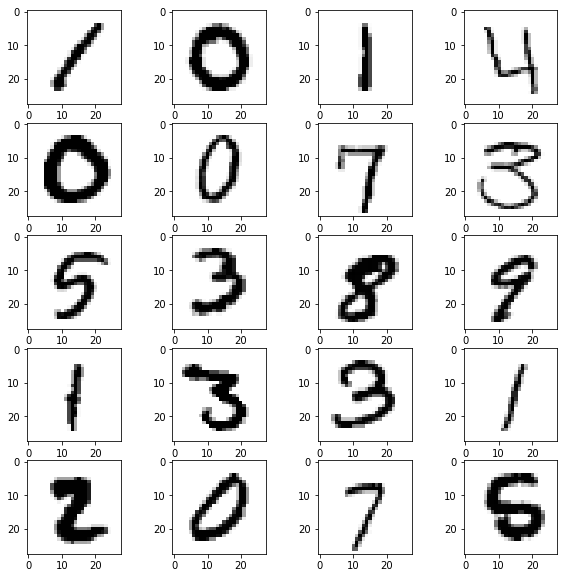

In [7]:
fig = plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train.iloc[i].values.reshape(28,28),cmap=plt.cm.binary)

### 2.4 Analyse the class distributions

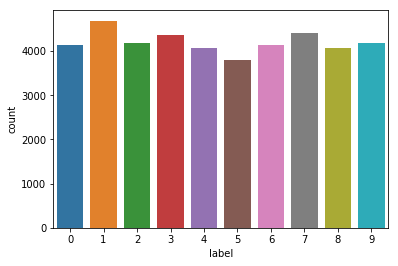

In [8]:
sns.countplot(Y)

# Models

## Model 1 - Simple Neural Network (Keras)

Accuracy on Kaggle learderboard: **%97.2**

Model has the features mentioned below:
* 3 layers (2 hidden + 1 output) - 784 --> (64,64) -->  (10)
* Learning Rate Reduction - LR will decrease when validation accuracy is not improved for 2 epochs in a row
* Regularization - 2 hidden layers will have L2 regularization

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
from keras import regularizers
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=784, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [11]:
# trainining
history = model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_split=0.1, callbacks = [learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Train on 37800 samples, validate on 4200 samples
Epoch 1/40
37800/37800 [==============================] - 6s 149us/step - loss: 0.6382 - acc: 0.8589 - val_loss: 0.3920 - val_acc: 0.9276
Epoch 2/40
37800/37800 [==============================] - 2s 63us/step - loss: 0.3482 - acc: 0.9369 - val_loss: 0.3163 - val_acc: 0.9462
Epoch 3/40
37800/37800 [==============================] - 2s 62us/step - loss: 0.2926 - acc: 0.9510 - val_loss: 0.2921 - val_acc: 0.9495
Epoch 4/40
37800/37800 [==============================] - 2s 63us/step - loss: 0.2589 - acc: 0.9598 - val_loss: 0.2502 - val_acc: 0.9602
Epoch 5/40
37800/37800 [==============================] - 2s 62us/step - loss: 0.2364 - acc: 0.9635 - val_loss: 0.2432 - val_acc: 0.9619
Epoch 6/40
37800/37800 [==============================] - 2s 63us/step - loss: 0.2192 - acc: 0.9680 - val_loss: 0.2292 - val_acc: 0.9629
Epoch 7/40
37800/37800 [==============================] - 2s 62us/step - loss: 0

In [12]:
# evaluate model on training data
res = model.evaluate(X_train, Y_train)
print("Model accuracy on training data is: %{}".format(res[1]*100))

42000/42000 [==============================] - 2s 53us/step
Model accuracy on training data is: %98.86904761904762


In [13]:
# Create submission
submission_df = pd.read_csv("../input/sample_submission.csv", index_col=0)
probs = model.predict(test)
submission_df['Label'] = np.argmax(probs,axis=1)
submission_df.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


## Model 2 - Convolutional Neural Network (Keras)

Accuracy on Kaggle learderboard: **%99.3** 

Model used is a VGG-like convnet from Keras website:



In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
___________________________

In [15]:
X_train_CNN = X_train.values.reshape((-1,28,28,1))
X_train_CNN.shape

(42000, 28, 28, 1)

In [16]:
model.fit(X_train_CNN, Y_train, batch_size=128, epochs=30)

Epoch 1/30
42000/42000 [==============================] - 6s 149us/step - loss: 0.7523 - acc: 0.7448
Epoch 2/30
42000/42000 [==============================] - 4s 86us/step - loss: 0.1655 - acc: 0.9493
Epoch 3/30
42000/42000 [==============================] - 4s 86us/step - loss: 0.1190 - acc: 0.9632
Epoch 4/30
42000/42000 [==============================] - 4s 87us/step - loss: 0.0958 - acc: 0.9697
Epoch 5/30
42000/42000 [==============================] - 4s 86us/step - loss: 0.0832 - acc: 0.9744
Epoch 6/30
42000/42000 [==============================] - 4s 87us/step - loss: 0.0737 - acc: 0.9779
Epoch 7/30
42000/42000 [==============================] - 4s 87us/step - loss: 0.0680 - acc: 0.9794
Epoch 8/30
42000/42000 [==============================] - 4s 86us/step - loss: 0.0606 - acc: 0.9809
Epoch 9/30
42000/42000 [==============================] - 4s 87us/step - loss: 0.0553 - acc: 0.9824
Epoch 10/30
42000/42000 [==============================] - 4s 87us/step - loss: 0.0501 - acc: 0.984

In [17]:
# evaluate model on training data
res2 = model.evaluate(X_train_CNN, Y_train)
print("Model accuracy on training data is: %{}".format(res2[1]*100))

42000/42000 [==============================] - 3s 73us/step
Model accuracy on training data is: %99.83095238095238


#### Alternatively augmentation can be used to train the model.

In [18]:
# datagen = ImageDataGenerator(
#     rotation_range = 15,
#     zca_whitening = True,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     )
# datagen.fit(X_train_CNN)

# history = model.fit_generator(datagen.flow(X_train_CNN,Y_train, batch_size=32),
#                               epochs = 10,
#                               verbose = 1, steps_per_epoch=steps_per_epoch=X_train_CNN.shape[0] // 32)

#### Create Submission

In [19]:
submission_df = pd.read_csv("../input/sample_submission.csv", index_col=0)
probs = model.predict(test.values.reshape((-1,28,28,1)))
submission_df['Label'] = np.argmax(probs,axis=1)
submission_df.head()


,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
